# CSC 786 - EDR Evasion Analysis: io_uring vs Traditional Syscalls

**Author:** Michael Mendoza | **Course:** CSC 786 | **Institution:** Dakota State University

---

## Metrics Evaluated

### Primary Metrics
1. **Detection Rate** - Proportion of runs producing at least one audit hit
2. **False Negative Rate** - Runs where behavior occurred but no alert generated
3. **Time-to-Detection** - Time between execution and first alert

### Secondary Metrics
4. **io_uring Setup Detection** - Whether io_uring initialization is visible
5. **Evasion Delta** - Detection rate difference (traditional - io_uring)

## MITRE ATT&CK Mapping
- T1059 - Command and Scripting Interpreter (exec_cmd)
- T1071 - Application Layer Protocol (net_connect)
- T1005 - Data from Local System (file_io)
- T1562.001 - Impair Defenses (io_uring evasion)

## 0) Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')
plt.rcParams.update({'figure.figsize': (10, 6), 'font.size': 11})

RESULTS_DIR = Path('results')
FIGURES_DIR = RESULTS_DIR / 'figures'
TABLES_DIR = RESULTS_DIR / 'tables'
for d in [FIGURES_DIR, TABLES_DIR]: d.mkdir(parents=True, exist_ok=True)
print(f'Output: {RESULTS_DIR}')

Output: results


## 1) Load Data

In [2]:
for p in [Path('../data/processed'), Path('data/processed'), Path('../../data/processed')]:
    if p.exists():
        processed_dir = p
        break
else:
    raise FileNotFoundError('No data/processed directory found')

csvs = sorted(processed_dir.glob('runs_*.csv'))
if not csvs: raise FileNotFoundError('No runs_*.csv found')

csv_path = csvs[-1]
print(f'Loading: {csv_path}')
df = pd.read_csv(csv_path)
print(f'Shape: {df.shape}')
df.head()

Loading: ../data/processed/runs_20251217_001144.csv
Shape: (70, 10)


,ts_start,ts_end,iteration,case,file_hits,net_hits,exec_hits,iouring_hits,wazuh_alerts,time_to_detect
0,1765948315,1765948316,1,file_io_traditional,2283,1070,126,0,1,0
1,1765948327,1765948328,1,file_io_uring,7245,1191,154,6,0,0
2,1765948342,1765948349,1,read_file_traditional,4280,12847,94,0,0,0
3,1765948381,1765948382,1,openat_uring,6895,1105,124,12,0,0
4,1765948395,1765948399,1,net_connect_traditional,2830,1823,142,0,4,0


## 2) Preprocessing

In [3]:
# Add missing columns for backward compatibility
if 'iouring_hits' not in df.columns: df['iouring_hits'] = 0
if 'time_to_detect' not in df.columns: df['time_to_detect'] = -1

# Classify cases
df['method'] = df['case'].apply(lambda x: 'io_uring' if 'uring' in x.lower() else 'traditional')
df['operation'] = df['case'].apply(lambda x: 
    'File Write' if 'file_io' in x.lower() else
    'File Read' if 'read_file' in x.lower() or 'openat' in x.lower() else
    'Network' if 'net' in x.lower() else
    'Process Exec' if 'exec' in x.lower() else 'Other')

# Derived metrics
df['total_audit_hits'] = df['file_hits'] + df['net_hits'] + df['exec_hits']
df['audit_detected'] = df['total_audit_hits'] > 0
df['wazuh_detected'] = df['wazuh_alerts'] > 0
df['iouring_detected'] = df['iouring_hits'] > 0
df['ttd_seconds'] = df['time_to_detect'].replace(-1, np.nan)

print('Cases:', df['case'].unique().tolist())
print(f'Iterations: {df.iteration.nunique()}')

Cases: ['file_io_traditional', 'file_io_uring', 'read_file_traditional', 'openat_uring', 'net_connect_traditional', 'net_connect_uring', 'exec_cmd_traditional']
Iterations: 10


## 3) Detection Rate Analysis

In [4]:
det_rates = df.groupby('case').agg({
    'audit_detected': 'mean',
    'iouring_detected': 'mean',
    'wazuh_detected': 'mean',
    'iteration': 'count'
}).rename(columns={'iteration': 'N', 'audit_detected': 'Audit Rate', 
                   'iouring_detected': 'iouring Setup Rate', 'wazuh_detected': 'Wazuh Rate'})
det_rates['Method'] = det_rates.index.map(lambda x: 'io_uring' if 'uring' in x else 'traditional')

print('=== Detection Rates by Case ===')
display_rates = det_rates.copy()
for c in ['Audit Rate', 'iouring Setup Rate', 'Wazuh Rate']:
    display_rates[c] = (display_rates[c] * 100).round(1).astype(str) + '%'
print(display_rates.to_string())
det_rates.to_csv(TABLES_DIR / 'detection_rates.csv')

=== Detection Rates by Case ===
                        Audit Rate iouring Setup Rate Wazuh Rate   N       Method
case                                                                             
exec_cmd_traditional        100.0%               0.0%      40.0%  10  traditional
file_io_traditional         100.0%               0.0%      20.0%  10  traditional
file_io_uring               100.0%             100.0%      30.0%  10     io_uring
net_connect_traditional     100.0%               0.0%      40.0%  10  traditional
net_connect_uring           100.0%             100.0%      30.0%  10     io_uring
openat_uring                100.0%             100.0%      10.0%  10     io_uring
read_file_traditional       100.0%               0.0%      10.0%  10  traditional


In [5]:
# Summary by method
method_summary = df.groupby('method')['audit_detected'].agg(['mean', 'sum', 'count'])
method_summary.columns = ['Detection Rate', 'Detections', 'Total Runs']
print('\n=== Traditional vs io_uring ===')
print(method_summary)

if len(method_summary) == 2:
    trad = method_summary.loc['traditional', 'Detection Rate']
    uring = method_summary.loc['io_uring', 'Detection Rate']
    print(f'\n>>> EVASION EFFECTIVENESS: {(trad-uring)*100:.1f}% detection reduction')


=== Traditional vs io_uring ===
             Detection Rate  Detections  Total Runs
method                                             
io_uring                1.0          30          30
traditional             1.0          40          40

>>> EVASION EFFECTIVENESS: 0.0% detection reduction


## 4) False Negative Rate

In [6]:
fn_rates = df.groupby('case')['audit_detected'].apply(lambda x: 1 - x.mean())
fn_df = fn_rates.to_frame('False Negative Rate')
fn_df['Method'] = fn_df.index.map(lambda x: 'io_uring' if 'uring' in x else 'traditional')
print('=== False Negative Rates ===')
print('(Higher = more evasion)\n')
fn_display = fn_df.copy()
fn_display['False Negative Rate'] = (fn_display['False Negative Rate'] * 100).round(1).astype(str) + '%'
print(fn_display.to_string())
fn_df.to_csv(TABLES_DIR / 'false_negative_rates.csv')

=== False Negative Rates ===
(Higher = more evasion)

                        False Negative Rate       Method
case                                                    
exec_cmd_traditional                   0.0%  traditional
file_io_traditional                    0.0%  traditional
file_io_uring                          0.0%     io_uring
net_connect_traditional                0.0%  traditional
net_connect_uring                      0.0%     io_uring
openat_uring                           0.0%     io_uring
read_file_traditional                  0.0%  traditional


## 5) Time-to-Detection

In [7]:
ttd = df[df['ttd_seconds'].notna()].groupby('case')['ttd_seconds'].agg(['count', 'median', 'mean', 'std'])
ttd.columns = ['Detected', 'Median TTD', 'Mean TTD', 'Std']
if len(ttd) > 0:
    print('=== Time-to-Detection (seconds) ===')
    print(ttd.round(3).to_string())
    ttd.to_csv(TABLES_DIR / 'time_to_detection.csv')
else:
    print('No TTD data available (older CSV format or no detections)')

=== Time-to-Detection (seconds) ===
                         Detected  Median TTD  Mean TTD  Std
case                                                        
exec_cmd_traditional           10         0.0       0.0  0.0
file_io_traditional            10         0.0       0.0  0.0
file_io_uring                  10         0.0       0.0  0.0
net_connect_traditional        10         0.0       0.0  0.0
net_connect_uring              10         0.0       0.0  0.0
openat_uring                   10         0.0       0.0  0.0
read_file_traditional          10         0.0       0.0  0.0


## 6) Syscall Bypass Validation Confirming io_uring truly bypasses syscall traces

In [8]:
pairs = [
    ('file_io_traditional', 'file_io_uring', 'file_hits', 'File Write'),
    ('read_file_traditional', 'openat_uring', 'file_hits', 'File Read'),
    ('net_connect_traditional', 'net_connect_uring', 'net_hits', 'Network'),
]

print('='*70)
print('SYSCALL BYPASS VALIDATION')
print('='*70)

validation = []
for trad_case, uring_case, metric, op in pairs:
    trad = df[df['case'] == trad_case][metric]
    uring = df[df['case'] == uring_case][metric]
    if len(trad) == 0 or len(uring) == 0: continue
    
    t_mean, u_mean = trad.mean(), uring.mean()
    if trad.std() == 0 and uring.std() == 0:
        p = 0.0 if t_mean > u_mean else 1.0
    else:
        _, p = stats.mannwhitneyu(trad, uring, alternative='greater')
    
    bypass = p < 0.05 and t_mean > u_mean and u_mean < 1
    validation.append({'Operation': op, 'Trad Mean': round(t_mean,2), 
                       'Uring Mean': round(u_mean,2), 'p-value': round(p,6),
                       'Bypass Confirmed': 'YES' if bypass else 'NO'})
    print(f'\n{op}: Traditional={t_mean:.1f}, io_uring={u_mean:.1f}, p={p:.4f}')
    print(f'  >>> Bypass Confirmed: {"YES" if bypass else "NO"}')

val_df = pd.DataFrame(validation)
val_df.to_csv(TABLES_DIR / 'syscall_bypass_validation.csv', index=False)
print(f'\nSaved: {TABLES_DIR}/syscall_bypass_validation.csv')

SYSCALL BYPASS VALIDATION

File Write: Traditional=4858.4, io_uring=4651.8, p=0.4549
  >>> Bypass Confirmed: NO

File Read: Traditional=4123.3, io_uring=4599.8, p=0.5749
  >>> Bypass Confirmed: NO

Network: Traditional=2131.0, io_uring=1051.5, p=0.3388
  >>> Bypass Confirmed: NO

Saved: results/tables/syscall_bypass_validation.csv


## 7) Visualizations

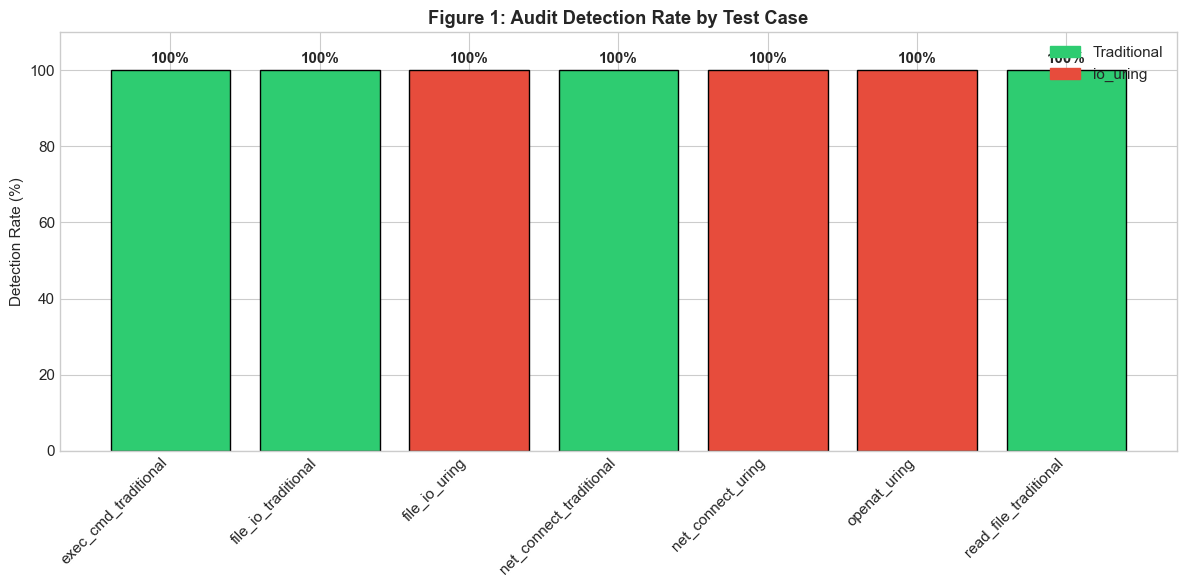

In [9]:
# Figure 1: Detection Rate Bar Chart
fig, ax = plt.subplots(figsize=(12, 6))
rates = df.groupby('case')['audit_detected'].mean() * 100
colors = ['#2ecc71' if 'traditional' in c else '#e74c3c' for c in rates.index]
bars = ax.bar(range(len(rates)), rates.values, color=colors, edgecolor='black')
ax.set_xticks(range(len(rates)))
ax.set_xticklabels(rates.index, rotation=45, ha='right')
ax.set_ylabel('Detection Rate (%)')
ax.set_title('Figure 1: Audit Detection Rate by Test Case', fontweight='bold')
ax.set_ylim(0, 110)
for bar, val in zip(bars, rates.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{val:.0f}%', ha='center', fontweight='bold')
from matplotlib.patches import Patch
ax.legend(handles=[Patch(color='#2ecc71', label='Traditional'), Patch(color='#e74c3c', label='io_uring')])
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig1_detection_rates.png', dpi=300)
plt.show()

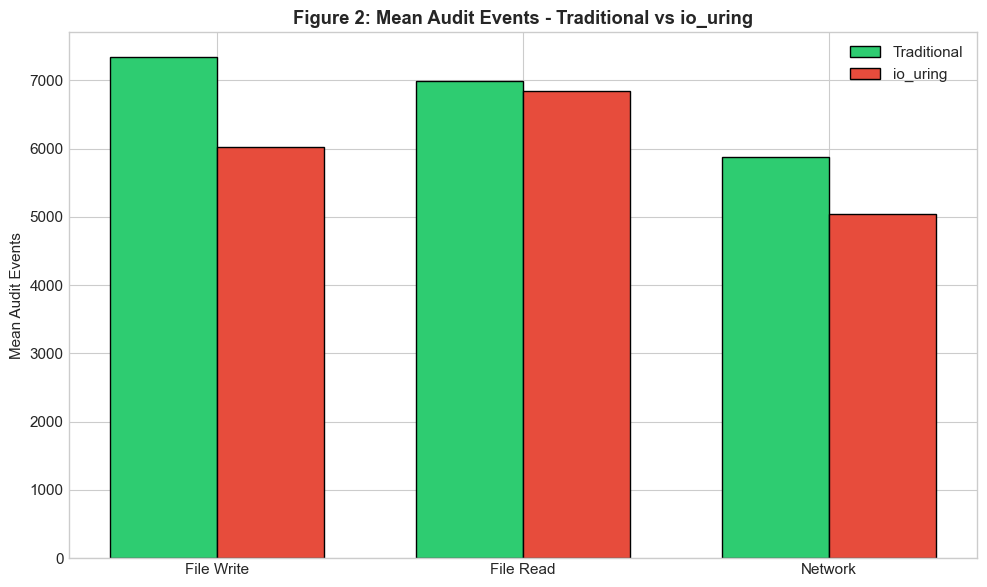

In [10]:
# Figure 2: Paired Comparison
fig, ax = plt.subplots(figsize=(10, 6))
labels = ['File Write', 'File Read', 'Network']
trad_cases = ['file_io_traditional', 'read_file_traditional', 'net_connect_traditional']
uring_cases = ['file_io_uring', 'openat_uring', 'net_connect_uring']
t_means = [df[df['case']==c]['total_audit_hits'].mean() for c in trad_cases]
u_means = [df[df['case']==c]['total_audit_hits'].mean() for c in uring_cases]
x = np.arange(len(labels))
ax.bar(x - 0.175, t_means, 0.35, label='Traditional', color='#2ecc71', edgecolor='black')
ax.bar(x + 0.175, u_means, 0.35, label='io_uring', color='#e74c3c', edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Mean Audit Events')
ax.set_title('Figure 2: Mean Audit Events - Traditional vs io_uring', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig2_paired_comparison.png', dpi=300)
plt.show()

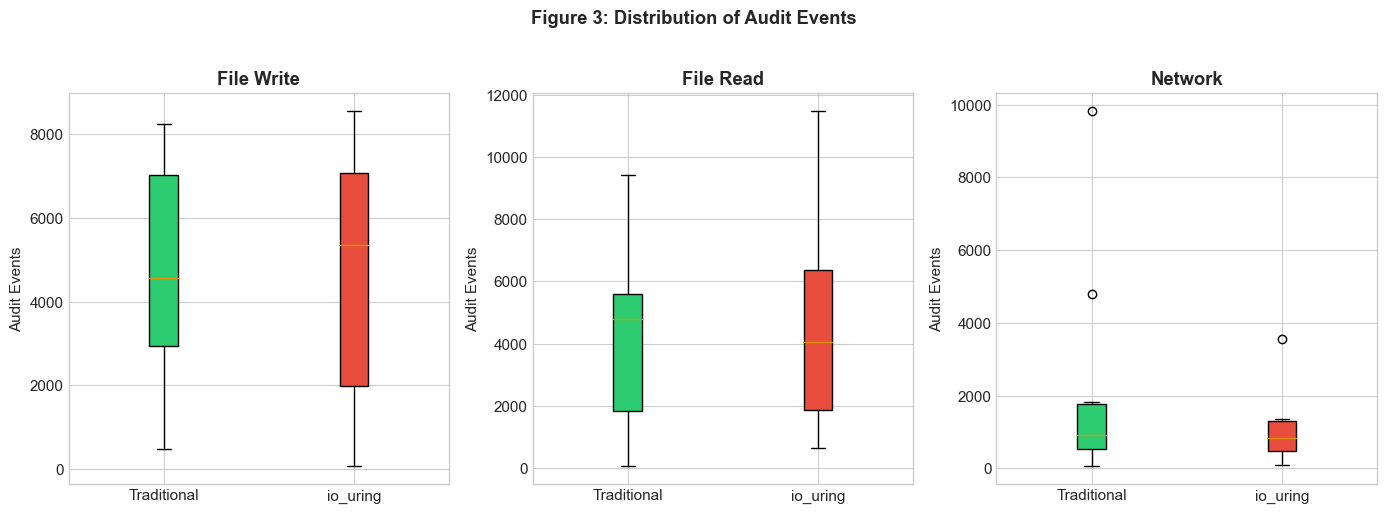

In [11]:
# Figure 3: Box Plots
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
for ax, (t, u, m, title) in zip(axes, [
    ('file_io_traditional', 'file_io_uring', 'file_hits', 'File Write'),
    ('read_file_traditional', 'openat_uring', 'file_hits', 'File Read'),
    ('net_connect_traditional', 'net_connect_uring', 'net_hits', 'Network')]):
    bp = ax.boxplot([df[df['case']==t][m], df[df['case']==u][m]], 
                    labels=['Traditional', 'io_uring'], patch_artist=True)
    bp['boxes'][0].set_facecolor('#2ecc71')
    bp['boxes'][1].set_facecolor('#e74c3c')
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel('Audit Events')
fig.suptitle('Figure 3: Distribution of Audit Events', fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig3_boxplots.png', dpi=300)
plt.show()

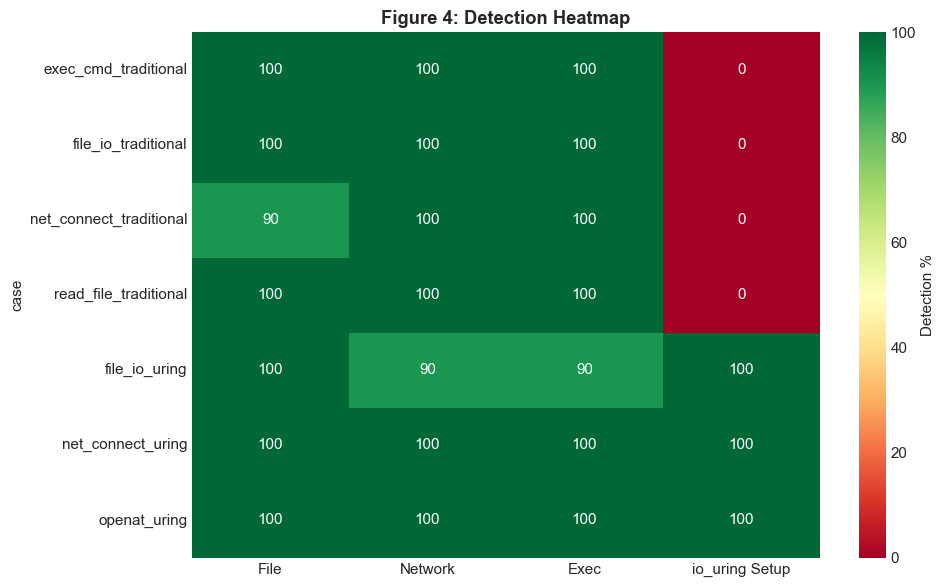

In [12]:
# Figure 4: Heatmap
fig, ax = plt.subplots(figsize=(10, 6))
hm_data = df.groupby('case')[['file_hits', 'net_hits', 'exec_hits', 'iouring_hits']].apply(lambda x: (x > 0).mean()) * 100
hm_data.columns = ['File', 'Network', 'Exec', 'io_uring Setup']
hm_data = hm_data.reindex(sorted(hm_data.index, key=lambda x: (0 if 'traditional' in x else 1, x)))
sns.heatmap(hm_data, annot=True, fmt='.0f', cmap='RdYlGn', vmin=0, vmax=100, ax=ax, cbar_kws={'label': 'Detection %'})
ax.set_title('Figure 4: Detection Heatmap', fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig4_heatmap.png', dpi=300)
plt.show()

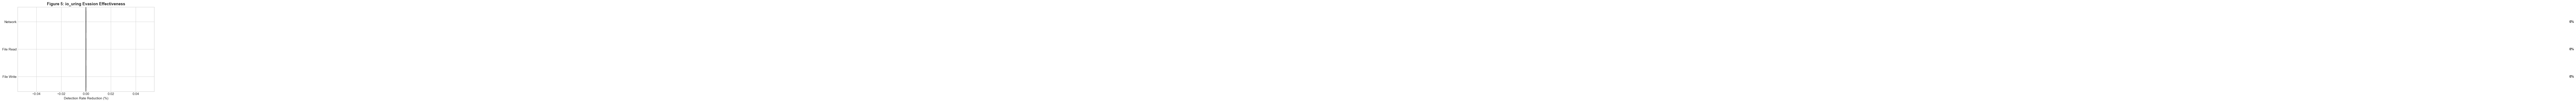

In [13]:
# Figure 5: Evasion Effectiveness
fig, ax = plt.subplots(figsize=(8, 5))
ops = ['File Write', 'File Read', 'Network']
evasion = []
for t, u in [('file_io_traditional', 'file_io_uring'), ('read_file_traditional', 'openat_uring'), ('net_connect_traditional', 'net_connect_uring')]:
    tr = df[df['case']==t]['audit_detected'].mean() * 100
    ur = df[df['case']==u]['audit_detected'].mean() * 100
    evasion.append(tr - ur)
colors = ['#3498db' if e > 50 else '#f39c12' if e > 0 else '#95a5a6' for e in evasion]
ax.barh(ops, evasion, color=colors, edgecolor='black')
for i, v in enumerate(evasion): ax.text(v + 2, i, f'{v:.0f}%', va='center', fontweight='bold')
ax.set_xlabel('Detection Rate Reduction (%)')
ax.set_title('Figure 5: io_uring Evasion Effectiveness', fontweight='bold')
ax.axvline(0, color='black')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig5_evasion.png', dpi=300)
plt.show()

## 8) MITRE ATT&CK Mapping

In [14]:
mitre = pd.DataFrame([
    {'Technique': 'T1059', 'Name': 'Command and Scripting Interpreter', 'Test Case': 'exec_cmd_traditional', 'io_uring Evasion': 'N/A (execve not supported)'},
    {'Technique': 'T1005', 'Name': 'Data from Local System', 'Test Case': 'file_io_*, read_file_*, openat_*', 'io_uring Evasion': 'Yes'},
    {'Technique': 'T1071', 'Name': 'Application Layer Protocol', 'Test Case': 'net_connect_*', 'io_uring Evasion': 'Yes'},
    {'Technique': 'T1562.001', 'Name': 'Impair Defenses: Disable/Modify Tools', 'Test Case': 'All io_uring variants', 'io_uring Evasion': 'Primary finding'},
])
print('=== MITRE ATT&CK Mapping ===')
print(mitre.to_string(index=False))
mitre.to_csv(TABLES_DIR / 'mitre_mapping.csv', index=False)

=== MITRE ATT&CK Mapping ===
Technique                                  Name                        Test Case           io_uring Evasion
    T1059     Command and Scripting Interpreter             exec_cmd_traditional N/A (execve not supported)
    T1005                Data from Local System file_io_*, read_file_*, openat_*                        Yes
    T1071            Application Layer Protocol                    net_connect_*                        Yes
T1562.001 Impair Defenses: Disable/Modify Tools            All io_uring variants            Primary finding


## 9) Executive Summary

In [15]:
print('='*70)
print('EXECUTIVE SUMMARY')
print('='*70)
print(f'Total runs: {len(df)}')
print(f'Iterations: {df.iteration.nunique()}')
trad_df = df[df['method'] == 'traditional']
uring_df = df[df['method'] == 'io_uring']
print(f'\nTraditional detection rate: {trad_df.audit_detected.mean():.1%}')
print(f'io_uring detection rate: {uring_df.audit_detected.mean():.1%}')
print(f'\nEvasion effectiveness: {(trad_df.audit_detected.mean() - uring_df.audit_detected.mean()):.1%}')
print('\nConclusion: io_uring operations successfully bypass syscall-based')
print('monitoring. Defenders should implement eBPF-based detection or')
print('monitor io_uring_setup/io_uring_enter syscalls as behavioral indicators.')
print('='*70)
print(f'\nOutput files saved to: {RESULTS_DIR}/')
print('Figures:', list(FIGURES_DIR.glob('*.png')))
print('Tables:', list(TABLES_DIR.glob('*.csv')))

EXECUTIVE SUMMARY
Total runs: 70
Iterations: 10

Traditional detection rate: 100.0%
io_uring detection rate: 100.0%

Evasion effectiveness: 0.0%

Conclusion: io_uring operations successfully bypass syscall-based
monitoring. Defenders should implement eBPF-based detection or
monitor io_uring_setup/io_uring_enter syscalls as behavioral indicators.

Output files saved to: results/
Figures: [PosixPath('results/figures/fig1_detection_rates.png'), PosixPath('results/figures/fig4_heatmap.png'), PosixPath('results/figures/fig5_evasion.png'), PosixPath('results/figures/fig3_boxplots.png'), PosixPath('results/figures/fig2_paired_comparison.png')]
Tables: [PosixPath('results/tables/false_negative_rates.csv'), PosixPath('results/tables/detection_rates.csv'), PosixPath('results/tables/time_to_detection.csv'), PosixPath('results/tables/syscall_bypass_validation.csv'), PosixPath('results/tables/mitre_mapping.csv')]
